# Setting up library

In [ ]:
#Import all the libraries. Some here are not necessary. I was testing other filters but due to time constraints only applied saturation, gaussian and salt and pepper functions.
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from skimage import io
import cv2 as cv
from PIL import Image
from sklearn.cluster import KMeans
from scipy import ndimage as nd
from skimage.filters import roberts, sobel, scharr, prewitt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset Import

Instructions for loading dataset:


1.   Download the GTRSB dataset from https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
2.   Import it to either colab notebook or add it to your google drive and mount.
3.   Unzip the folder using: !unzip [file location]



In [ ]:
#Mount from Google Drive if you have it there.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Setup

In [ ]:
#Open the zip folder and extract its contents to the colab file system.
!unzip /content/drive/MyDrive/Colab_datasets/Traffic_sign_ds.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

# Regular CNN Model (No filter preprocessing)

In [ ]:
#Our first CNN model will serve as the control group. No filters are added.

#Instantiate two arrays. One for the images and one for the classes.
image_data = []
class_labels = []

#We then iterate through the training image folder and open each image. For each image, we first resize the dimensions to 30x30 to standardize and then convert the image into an array. The array values are then nested into the image array and add its corresponding class to the label array.
for i in range(43):

    directory_path = os.path.join("/content/Train/", str(i))
    print(directory_path)
    image_files = os.listdir(directory_path)
    print(image_files)
    for image_file in image_files:
        try:
            img_path = os.path.join(directory_path, image_file)
            img = Image.open(img_path).resize((30,30))
            img_array = np.array(img)
            image_data.append(img_array)
            class_labels.append(i)
        except Exception as error:
            print(f"Failed to process image {image_file}: {error}")

image_data = np.array(image_data)
class_labels = np.array(class_labels)

/content/Train/0
['00000_00004_00010.png', '00000_00003_00000.png', '00000_00002_00003.png', '00000_00005_00023.png', '00000_00005_00000.png', '00000_00003_00020.png', '00000_00003_00023.png', '00000_00003_00027.png', '00000_00000_00027.png', '00000_00005_00020.png', '00000_00002_00013.png', '00000_00000_00012.png', '00000_00001_00028.png', '00000_00000_00009.png', '00000_00006_00009.png', '00000_00001_00018.png', '00000_00000_00010.png', '00000_00000_00000.png', '00000_00004_00006.png', '00000_00003_00005.png', '00000_00003_00028.png', '00000_00003_00017.png', '00000_00006_00022.png', '00000_00002_00024.png', '00000_00003_00002.png', '00000_00004_00015.png', '00000_00005_00021.png', '00000_00000_00025.png', '00000_00002_00015.png', '00000_00006_00019.png', '00000_00006_00001.png', '00000_00002_00012.png', '00000_00000_00020.png', '00000_00001_00003.png', '00000_00005_00002.png', '00000_00002_00014.png', '00000_00001_00022.png', '00000_00003_00016.png', '00000_00000_00024.png', '00000_

In [ ]:
#Checking to make sure the images are actually added.
image_data[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 46,  56,  66],
        [ 46,  54,  62],
        [119, 108,  98],
        ...,
        [255, 255, 249],
        [255, 255, 246],
        [255, 255, 246]],

       [[ 47,  57,  67],
        [ 48,  57,  68],
        [119, 109, 102],
        ...,
        [255, 255, 248],
        [255, 255, 250],
        [255, 255, 249]],

       [[ 45,  54,  64],
        [ 51,  57,  67],
        [119, 108, 103],
        ...,
        [255, 255, 250],
        [255, 255, 247],
        [255, 255, 248]]], dtype=uint8)

In [ ]:
#Splitting the dataset. The test size comprises of 20% of the dataset.
X_train, X_test, y_train, y_test = train_test_split(image_data, class_labels, test_size=0.2, random_state=42)

#Normalize the training and test data.
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#one hot encoding.
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [ ]:
#CNN model setup.
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.50))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#Show model architecture.
model.summary()
epochs = 10
#Fit the model to run the model. Each CNN is tested for 10 epochs.
history = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_17 (Flatten)        (None, 2304)            

# Saturation Model

In [ ]:
# CNN model trained with images preprocessed through a saturation filter.
def saturation_image(image):
    img_data = np.asarray(image)

    [rows, cols, depth] = img_data.shape


    grayscale_img_data = np.zeros((rows, cols, depth), dtype=np.uint8)

    grayscale_img_data[:,:,0] = np.mean(img_data,axis=2) * 1.25
    grayscale_img_data[:,:,1] = np.mean(img_data,axis=2) * 1.50
    grayscale_img_data[:,:,2] = np.mean(img_data,axis=2) * 1.75


    grayscale_img = Image.fromarray(grayscale_img_data)
    return grayscale_img

image_data_sat = []
class_labels_sat = []

for i in range(43):
    directory_path = os.path.join("/content/Train/", str(i))
    image_files = os.listdir(directory_path)

    for image_file in image_files:
        try:
            img_path = os.path.join(directory_path, image_file)
            img = Image.open(img_path).resize((30, 30))
            sat_img = saturation_image(img)
            img_array = np.array(sat_img)
            image_data_sat.append(img_array)
            class_labels_sat.append(i)
        except Exception as error:
            print(f"Failed to process image {image_file}: {error}")


image_data_sat = np.array(image_data_sat)
class_labels_sat = np.array(class_labels_sat)

In [ ]:
#Checking to make sure the images are actually modified with saturation.
image_data_sat[0]

array([[[ 62, 126, 190],
        [ 62, 126, 190],
        [ 62, 126, 190],
        ...,
        [ 62, 126, 190],
        [ 62, 126, 190],
        [ 62, 126, 190]],

       [[ 62, 126, 190],
        [ 62, 126, 190],
        [ 62, 126, 190],
        ...,
        [ 62, 126, 190],
        [ 62, 126, 190],
        [ 62, 126, 190]],

       [[ 62, 126, 190],
        [ 62, 126, 190],
        [ 62, 126, 190],
        ...,
        [ 62, 126, 190],
        [ 62, 126, 190],
        [ 62, 126, 190]],

       ...,

       [[ 70,  84,  98],
        [ 67,  81,  94],
        [135, 162, 189],
        ...,
        [ 60, 123, 186],
        [ 59, 122, 185],
        [ 59, 122, 185]],

       [[ 71,  85,  99],
        [ 72,  86, 100],
        [137, 165, 192],
        ...,
        [ 59, 123, 186],
        [ 60, 124, 187],
        [ 60, 123, 186]],

       [[ 67,  81,  95],
        [ 72,  87, 102],
        [137, 165, 192],
        ...,
        [ 60, 124, 187],
        [ 59, 122, 185],
        [ 59, 123, 186]]], dtype=uint8)

In [ ]:
#Splitting the dataset
X_Sat_train, X_Sat_test, y_Sat_train, y_Sat_test = train_test_split(image_data_sat, class_labels_sat, test_size=0.2, random_state=42)
X_Sat_train = X_train.astype('float32') / 255
X_Sat_test = X_test.astype('float32') / 255

print(X_Sat_train.shape, X_Sat_test.shape, y_Sat_train.shape, y_Sat_test.shape)


y_Sat_train = to_categorical(y_Sat_train, 43)
y_Sat_test = to_categorical(y_Sat_test, 43)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [ ]:
sat_model = Sequential()
sat_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=X_Sat_train.shape[1:]))
sat_model.add(MaxPool2D(pool_size=(2, 2)))
sat_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
sat_model.add(MaxPool2D(pool_size=(2, 2)))
sat_model.add(Dropout(rate=0.50))
sat_model.add(Flatten())
sat_model.add(Dense(43, activation='softmax'))

sat_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

sat_model.summary()

epochs = 10
sat_history = sat_model.fit(X_Sat_train, y_Sat_train, batch_size=128, epochs=epochs, validation_split=0.2)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_19 (Flatten)        (None, 2304)            

# Gaussian Blur Model

In [ ]:
#Code for Gaussian blur CNN
def gaussian_blur_image(image):
 kernel = cv.getGaussianKernel(ksize=5,sigma=5)
 image_conv = cv.filter2D(image, -1, kernel)
 return image_conv

image_data_gauss = []
class_labels_gauss = []


for i in range(43):
    directory_path = os.path.join("/content/Train/", str(i))
    image_files = os.listdir(directory_path)

    for image_file in image_files:
        try:
            img_path = os.path.join(directory_path, image_file)
            img = Image.open(img_path).resize((30, 30))
            img_array = np.array(img)
            gauss_img = gaussian_blur_image(img_array)

            image_data_gauss.append(gauss_img)
            class_labels_gauss.append(i)
        except Exception as error:
            print(f"Failed to process image {image_file}: {error}")


image_data_gauss = np.array(image_data_gauss)
class_labels_gauss = np.array(class_labels_gauss)

In [ ]:
#Checking to make sure the images are actually modified with gaussian blur.
image_data_gauss[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 254]],

       [[251, 253, 254],
        [250, 251, 253],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 253]],

       ...,

       [[ 47,  57,  67],
        [ 49,  56,  65],
        [120, 110, 101],
        ...,
        [255, 255, 249],
        [255, 255, 248],
        [255, 255, 249]],

       [[ 46,  56,  66],
        [ 48,  56,  65],
        [120, 109, 101],
        ...,
        [255, 255, 249],
        [255, 255, 248],
        [255, 255, 248]],

       [[ 46,  56,  66],
        [ 48,  56,  65],
        [119, 108, 101],
        ...,
        [255, 255, 249],
        [255, 255, 248],
        [255, 255, 248]]], dtype=uint8)

In [ ]:
X_Gauss_train, X_Gauss_test, y_Gauss_train, y_Gauss_test = train_test_split(image_data_gauss, class_labels_gauss, test_size=0.2, random_state=42)
X_Gauss_train = X_train.astype('float32') / 255
X_Gauss_test = X_test.astype('float32') / 255

print(X_Gauss_train.shape, X_Gauss_test.shape, y_Gauss_train.shape, y_Gauss_test.shape)


y_Gauss_train = to_categorical(y_Gauss_train, 43)
y_Gauss_test = to_categorical(y_Gauss_test, 43)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [ ]:
gauss_model = Sequential()
gauss_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=X_Gauss_train.shape[1:]))
gauss_model.add(MaxPool2D(pool_size=(2, 2)))
gauss_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
gauss_model.add(MaxPool2D(pool_size=(2, 2)))
gauss_model.add(Dropout(rate=0.50))
gauss_model.add(Flatten())
gauss_model.add(Dense(43, activation='softmax'))

gauss_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

gauss_model.summary()

epochs = 10
gauss_history = gauss_model.fit(X_Gauss_train, y_Gauss_train, batch_size=128, epochs=epochs, validation_split=0.2)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_16 (Flatten)        (None, 2304)            

# Salt and Pepper Noise Model
The Salt and Pepper filter is a noise function which randomly distributes black and white pixels throughout the image, creating a more intense and saturated kind of noise. Noise levels can be adjusted to add more or less noise to the image. In this code section, we write three more CNN models which are trained on datasets which vary in noise levels.

## Salt and Pepper 0.25 Noise Model

In [ ]:
#CNN code for Salt and Pepper 0.25
image_data_sp = []
class_labels_sp = []
total_classes = 43
#Function to apply Salt and Pepper function. Each SP CNN has a hardcoded noise level.
def salt_and_pepper_image(image):
     noise_level = 0.25
     gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
     [rows, cols] = gray.shape
     grayscale_img_data = np.zeros((rows,cols))
     for i in range(rows):
        for j in range(cols):
            probability = np.random.random()
            if(probability < noise_level):
               grayscale_img_data[i,j] = np.random.choice([0,255])
            else:
               grayscale_img_data[i,j] = gray[i][j]
     grayscale_img_data = np.clip(grayscale_img_data, 0, 255)
     noise_img = Image.fromarray(grayscale_img_data.astype(np.uint8))
     return grayscale_img_data

for i in range(total_classes):
    directory_path = os.path.join("/content/Train/", str(i))
    image_files = os.listdir(directory_path)

    for image_file in image_files:
        try:
            img_path = os.path.join(directory_path, image_file)
            img = Image.open(img_path).resize((30, 30))
            img_array = np.array(img)
            sp_img = salt_and_pepper_image(img_array)
            sp_img = np.expand_dims(sp_img, axis=-1)
            image_data_sp.append(sp_img)
            class_labels_sp.append(i)
        except Exception as error:
            print(f"Failed to process image {image_file}: {error}")

image_data_sp = np.array(image_data_sp)
class_labels_sp = np.array(class_labels_sp)

print(image_data_sp[0])

X_SP25_train, X_SP25_test, y_SP25_train, y_SP25_test = train_test_split(image_data_sp, class_labels_sp, test_size=0.2, random_state=42)
X_SP25_train = X_SP25_train.astype('float32') / 255
X_SP25_test = X_SP25_test.astype('float32') / 255

print(X_SP25_train.shape, X_SP25_test.shape, y_SP25_train.shape, y_SP25_test.shape)


y_SP25_train = to_categorical(y_SP25_train, 43)
y_SP25_test = to_categorical(y_SP25_test, 43)
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=X_SP25_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.50))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

epochs = 10
historySP025 = model.fit(X_SP25_train, y_SP25_train, batch_size=128, epochs=epochs, validation_split=0.2)

[[[255.]
  [255.]
  [255.]
  [255.]
  [220.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [184.]
  [ 49.]
  [  0.]
  [ 37.]
  [  0.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]]

 [[  0.]
  [255.]
  [  0.]
  [255.]
  [219.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [255.]
  [182.]
  [255.]
  [ 46.]
  [ 36.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [255.]
  [255.]
  [255.]]

 [[255.]
  [255.]
  [255.]
  [255.]
  [218.]
  [243.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [190.]
  [ 55.]
  [255.]
  [255.]
  [153.]
  [254.]
  [255.]
  [  0.]
  [255.]
  [255.]
  [  0.]
  [  0.]
  [255.]
  [255.]
  [  0.]
  [  0.]]

 [[255.]
  [255.]
  [255.]
  [255.]
  [216.]
  [  0.]
  [255.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [253.]
  [220.]
  [164.]
  [159.]
  [154.]
  [207.]
  [255.]
  [2

## Salt and Pepper 0.50 Model

In [ ]:
#CNN code for Salt and Pepper 0.50
image_data_sp = []
class_labels_sp = []
total_classes = 43
def salt_and_pepper_image(image):
     noise_level = 0.50
     gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
     [rows, cols] = gray.shape
     grayscale_img_data = np.zeros((rows,cols))
     for i in range(rows):
        for j in range(cols):
            probability = np.random.random()
            if(probability < noise_level):
               grayscale_img_data[i,j] = np.random.choice([0,255])
            else:
               grayscale_img_data[i,j] = gray[i][j]
     grayscale_img_data = np.clip(grayscale_img_data, 0, 255)
     noise_img = Image.fromarray(grayscale_img_data.astype(np.uint8))
     return grayscale_img_data

for i in range(total_classes):
    directory_path = os.path.join("/content/Train/", str(i))
    image_files = os.listdir(directory_path)

    for image_file in image_files:
        try:
            img_path = os.path.join(directory_path, image_file)
            img = Image.open(img_path).resize((30, 30))
            img_array = np.array(img)
            sp_img = salt_and_pepper_image(img_array)
            sp_img = np.expand_dims(sp_img, axis=-1)
            image_data_sp.append(sp_img)
            class_labels_sp.append(i)
        except Exception as error:
            print(f"Failed to process image {image_file}: {error}")

image_data_sp = np.array(image_data_sp)
class_labels_sp = np.array(class_labels_sp)

print(image_data_sp[0])
X_SP50_train, X_SP50_test, y_SP50_train, y_SP50_test = train_test_split(image_data_sp, class_labels_sp, test_size=0.2, random_state=42)
X_SP50_train = X_SP50_train.astype('float32') / 255
X_SP50_test = X_SP50_test.astype('float32') / 255

print(X_SP50_train.shape, X_SP50_test.shape, y_SP50_train.shape, y_SP50_test.shape)


y_SP50_train = to_categorical(y_SP50_train, 43)
y_SP50_test = to_categorical(y_SP50_test, 43)
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=X_SP50_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.50))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

epochs = 10
historySP050 = model.fit(X_SP50_train, y_SP50_train, batch_size=128, epochs=epochs, validation_split=0.2)

[[[  0.]
  [255.]
  [255.]
  [  0.]
  [220.]
  [243.]
  [  0.]
  [255.]
  [255.]
  [  0.]
  [  0.]
  [255.]
  [255.]
  [  0.]
  [184.]
  [ 49.]
  [255.]
  [255.]
  [  0.]
  [255.]
  [  0.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [  0.]
  [255.]
  [  0.]
  [255.]]

 [[255.]
  [  0.]
  [255.]
  [255.]
  [219.]
  [243.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [182.]
  [ 47.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [255.]]

 [[255.]
  [255.]
  [255.]
  [255.]
  [218.]
  [243.]
  [255.]
  [  0.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [  0.]
  [190.]
  [255.]
  [  0.]
  [ 41.]
  [  0.]
  [254.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [255.]
  [255.]
  [  0.]
  [255.]]

 [[255.]
  [  0.]
  [  0.]
  [255.]
  [216.]
  [  0.]
  [  0.]
  [255.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [255.]
  [220.]
  [  0.]
  [  0.]
  [  0.]
  [207.]
  [255.]
  [ 

## Salt and Pepper 0.75 Model


In [ ]:
#CNN code for Salt and Pepper 0.75
image_data_sp = []
class_labels_sp = []
total_classes = 43
def salt_and_pepper_image(image):
     noise_level = 0.75
     gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
     [rows, cols] = gray.shape
     grayscale_img_data = np.zeros((rows,cols))
     for i in range(rows):
        for j in range(cols):
            probability = np.random.random()
            if(probability < noise_level):
               grayscale_img_data[i,j] = np.random.choice([0,255])
            else:
               grayscale_img_data[i,j] = gray[i][j]
     grayscale_img_data = np.clip(grayscale_img_data, 0, 255)
     noise_img = Image.fromarray(grayscale_img_data.astype(np.uint8))
     return grayscale_img_data

for i in range(total_classes):
    directory_path = os.path.join("/content/Train/", str(i))
    image_files = os.listdir(directory_path)

    for image_file in image_files:
        try:
            img_path = os.path.join(directory_path, image_file)
            img = Image.open(img_path).resize((30, 30))
            img_array = np.array(img)
            sp_img = salt_and_pepper_image(img_array)
            sp_img = np.expand_dims(sp_img, axis=-1)
            image_data_sp.append(sp_img)
            class_labels_sp.append(i)
        except Exception as error:
            print(f"Failed to process image {image_file}: {error}")

image_data_sp = np.array(image_data_sp)
class_labels_sp = np.array(class_labels_sp)

print(image_data_sp[0])

X_SP75_train, X_SP75_test, y_SP75_train, y_SP75_test = train_test_split(image_data_sp, class_labels_sp, test_size=0.2, random_state=42)
X_SP75_train = X_SP75_train.astype('float32') / 255
X_SP75_test = X_SP75_test.astype('float32') / 255

print(X_SP75_train.shape, X_SP75_test.shape, y_SP75_train.shape, y_SP75_test.shape)


y_SP75_train = to_categorical(y_SP75_train, 43)
y_SP75_test = to_categorical(y_SP75_test, 43)
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=X_SP75_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.50))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

epochs = 10
historySP075 = model.fit(X_SP75_train, y_SP75_train, batch_size=128, epochs=epochs, validation_split=0.2)

[[[  0.]
  [255.]
  [  0.]
  [255.]
  [  0.]
  [255.]
  [  0.]
  [  0.]
  [255.]
  [255.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [  0.]
  [255.]
  [255.]
  [  0.]
  [255.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [255.]
  [  0.]
  [255.]
  [255.]
  [255.]]

 [[  0.]
  [  0.]
  [255.]
  [255.]
  [  0.]
  [243.]
  [255.]
  [  0.]
  [255.]
  [  0.]
  [255.]
  [255.]
  [  0.]
  [  0.]
  [  0.]
  [255.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [255.]
  [  0.]
  [255.]]

 [[255.]
  [255.]
  [255.]
  [  0.]
  [  0.]
  [243.]
  [  0.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [255.]
  [  0.]
  [  0.]
  [255.]
  [ 41.]
  [255.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [255.]
  [  0.]
  [  0.]
  [  0.]
  [255.]
  [  0.]]

 [[255.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [242.]
  [255.]
  [  0.]
  [255.]
  [255.]
  [255.]
  [255.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [255.]
  [154.]
  [  0.]
  [255.]
  [ 

# Results Graphs

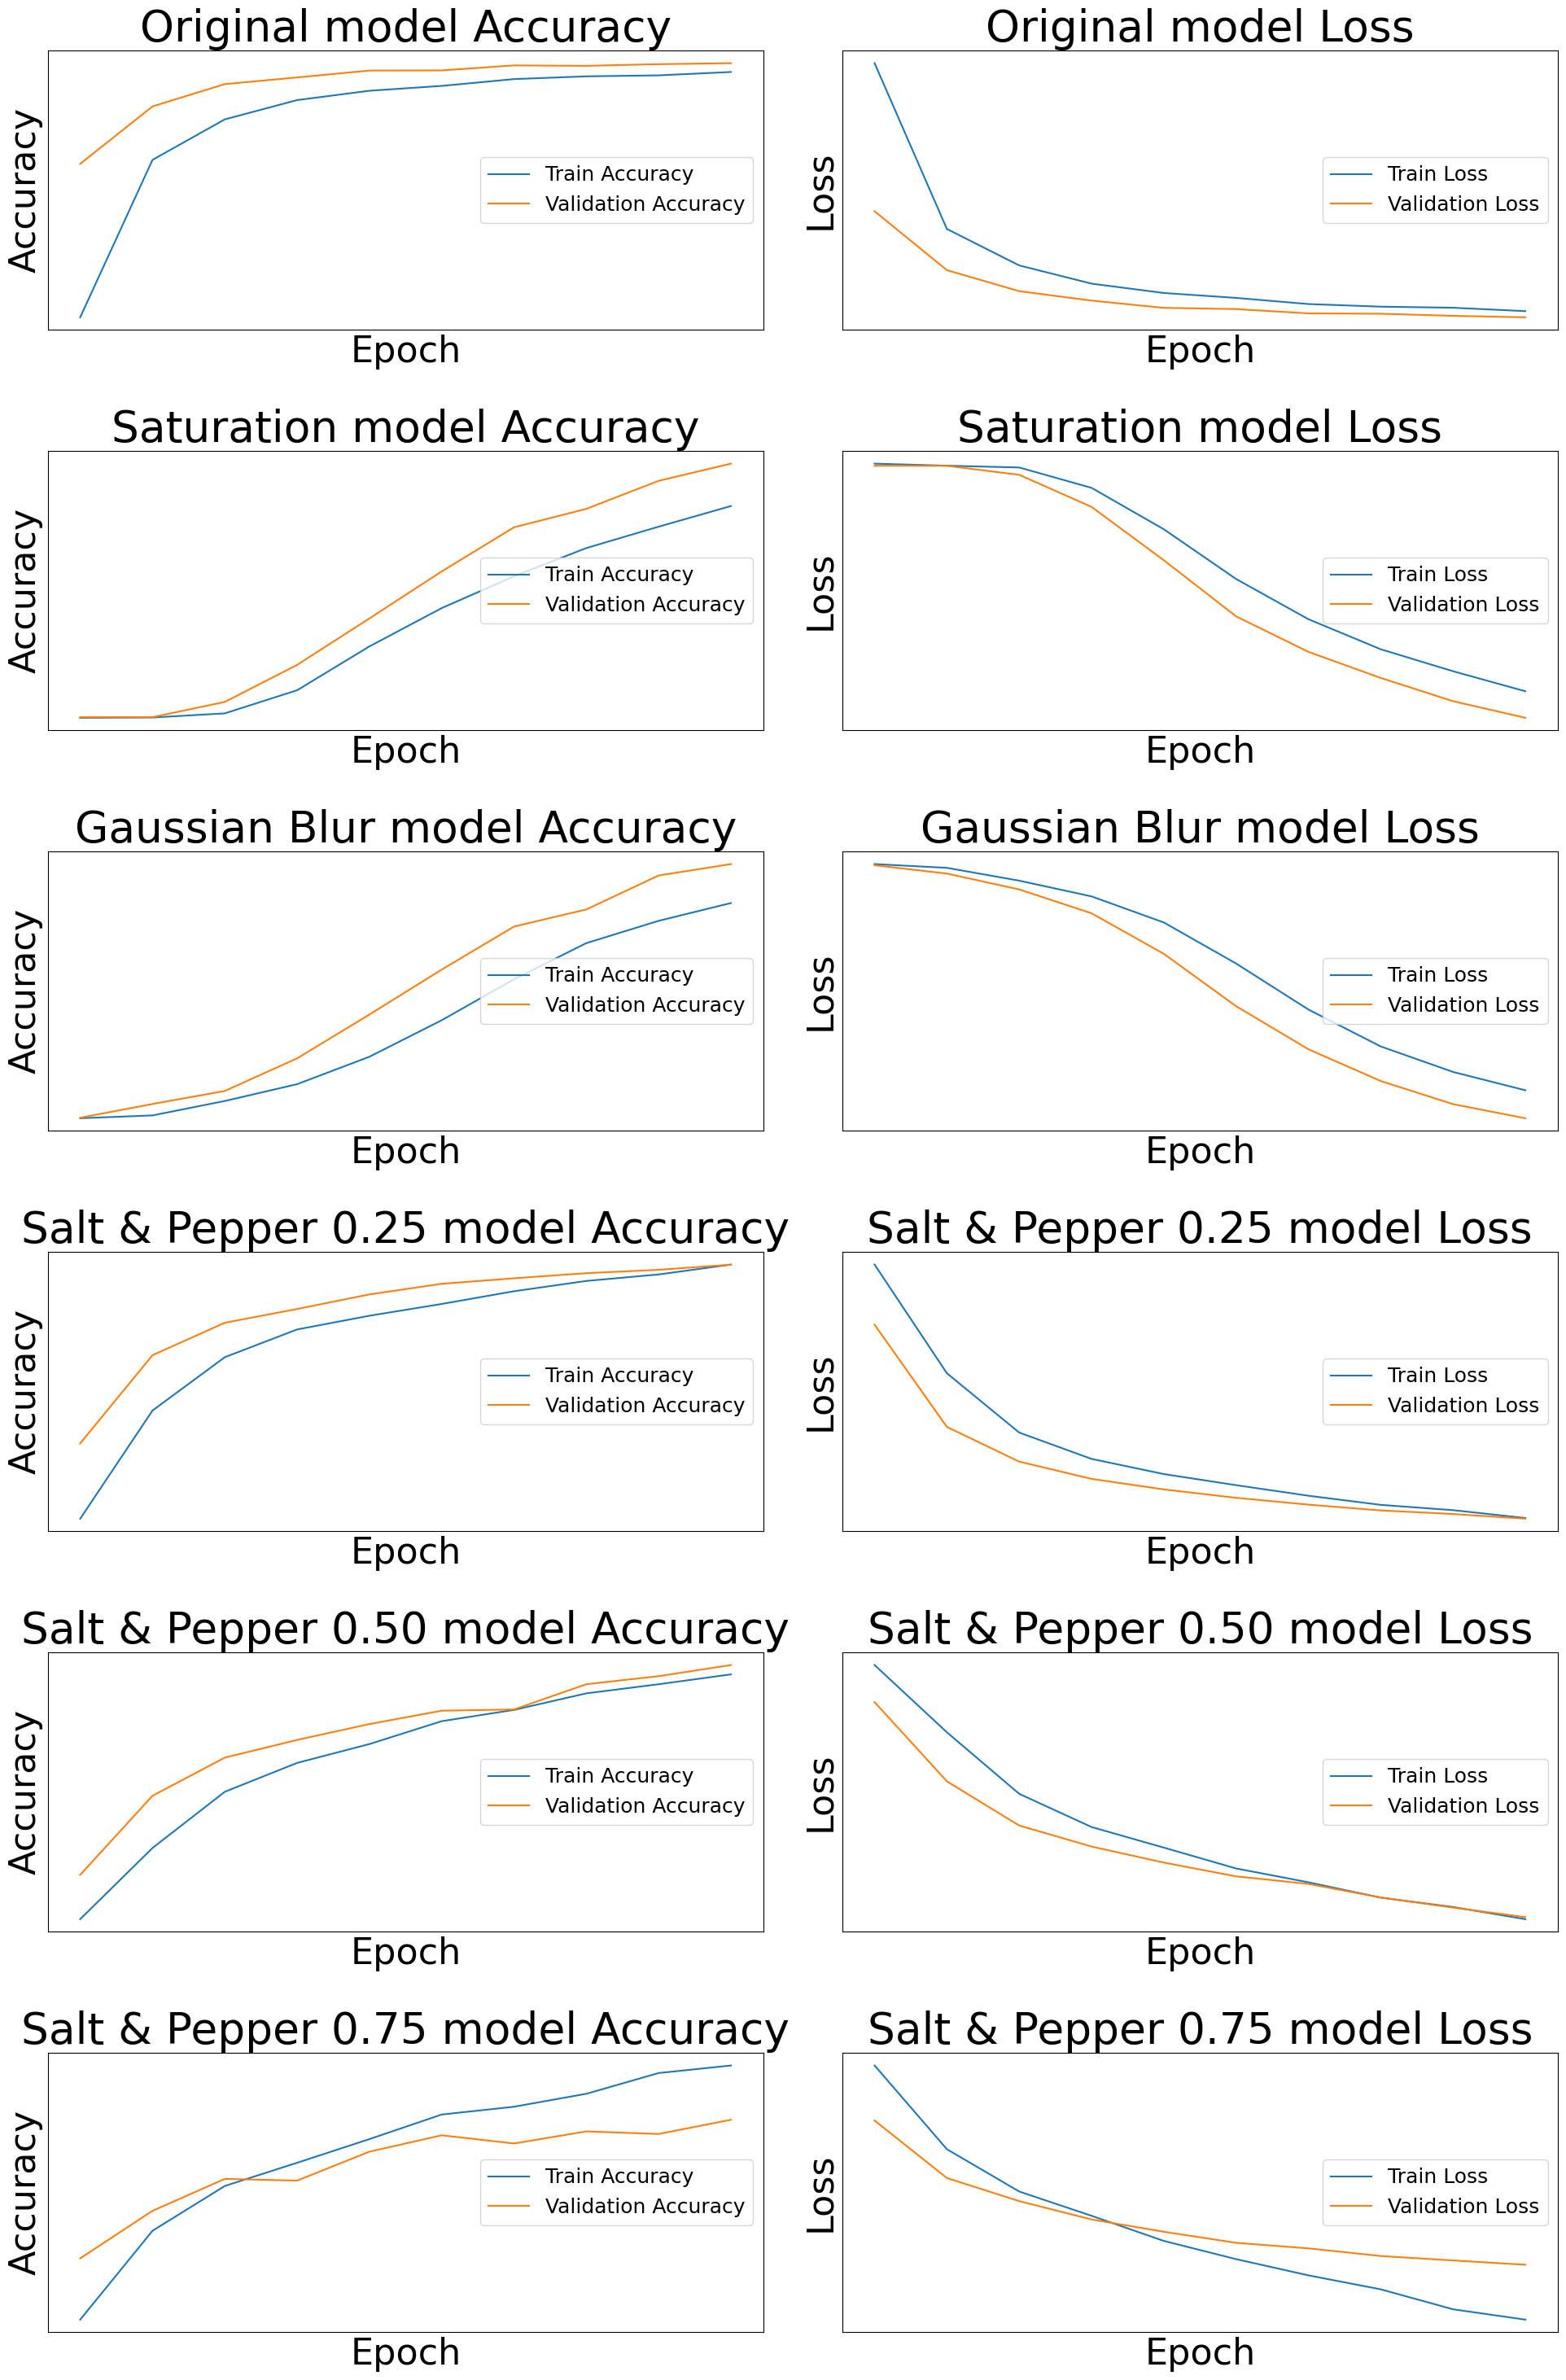

In [ ]:
#Creating a 2x6 plot chart showing the accuracy and loss of each CNN. For each one, we also include the training and validation set accuracy and loss.
plt.rcParams.update({'font.size': 32})
plt.rcParams['legend.fontsize'] = 18
histories = [history, sat_history, gauss_history, historySP025, historySP050, historySP075]
titles = ['Original model', 'Saturation model', 'Gaussian Blur model', 'Salt & Pepper 0.25 model', 'Salt & Pepper 0.50 model', 'Salt & Pepper 0.75 model']

plt.figure(figsize=(20, 30))

for i, history in enumerate(histories):
    #Define dimensions for accuracy plot for each CNN.
    plt.subplot(6, 2, 2 * i + 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(titles[i] + ' Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='center right')
    plt.xticks([]), plt.yticks([])

    #Define dimensions for loss function plot for each CNN.
    plt.subplot(6, 2, 2 * i + 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(titles[i] + ' Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='center right')
    plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()

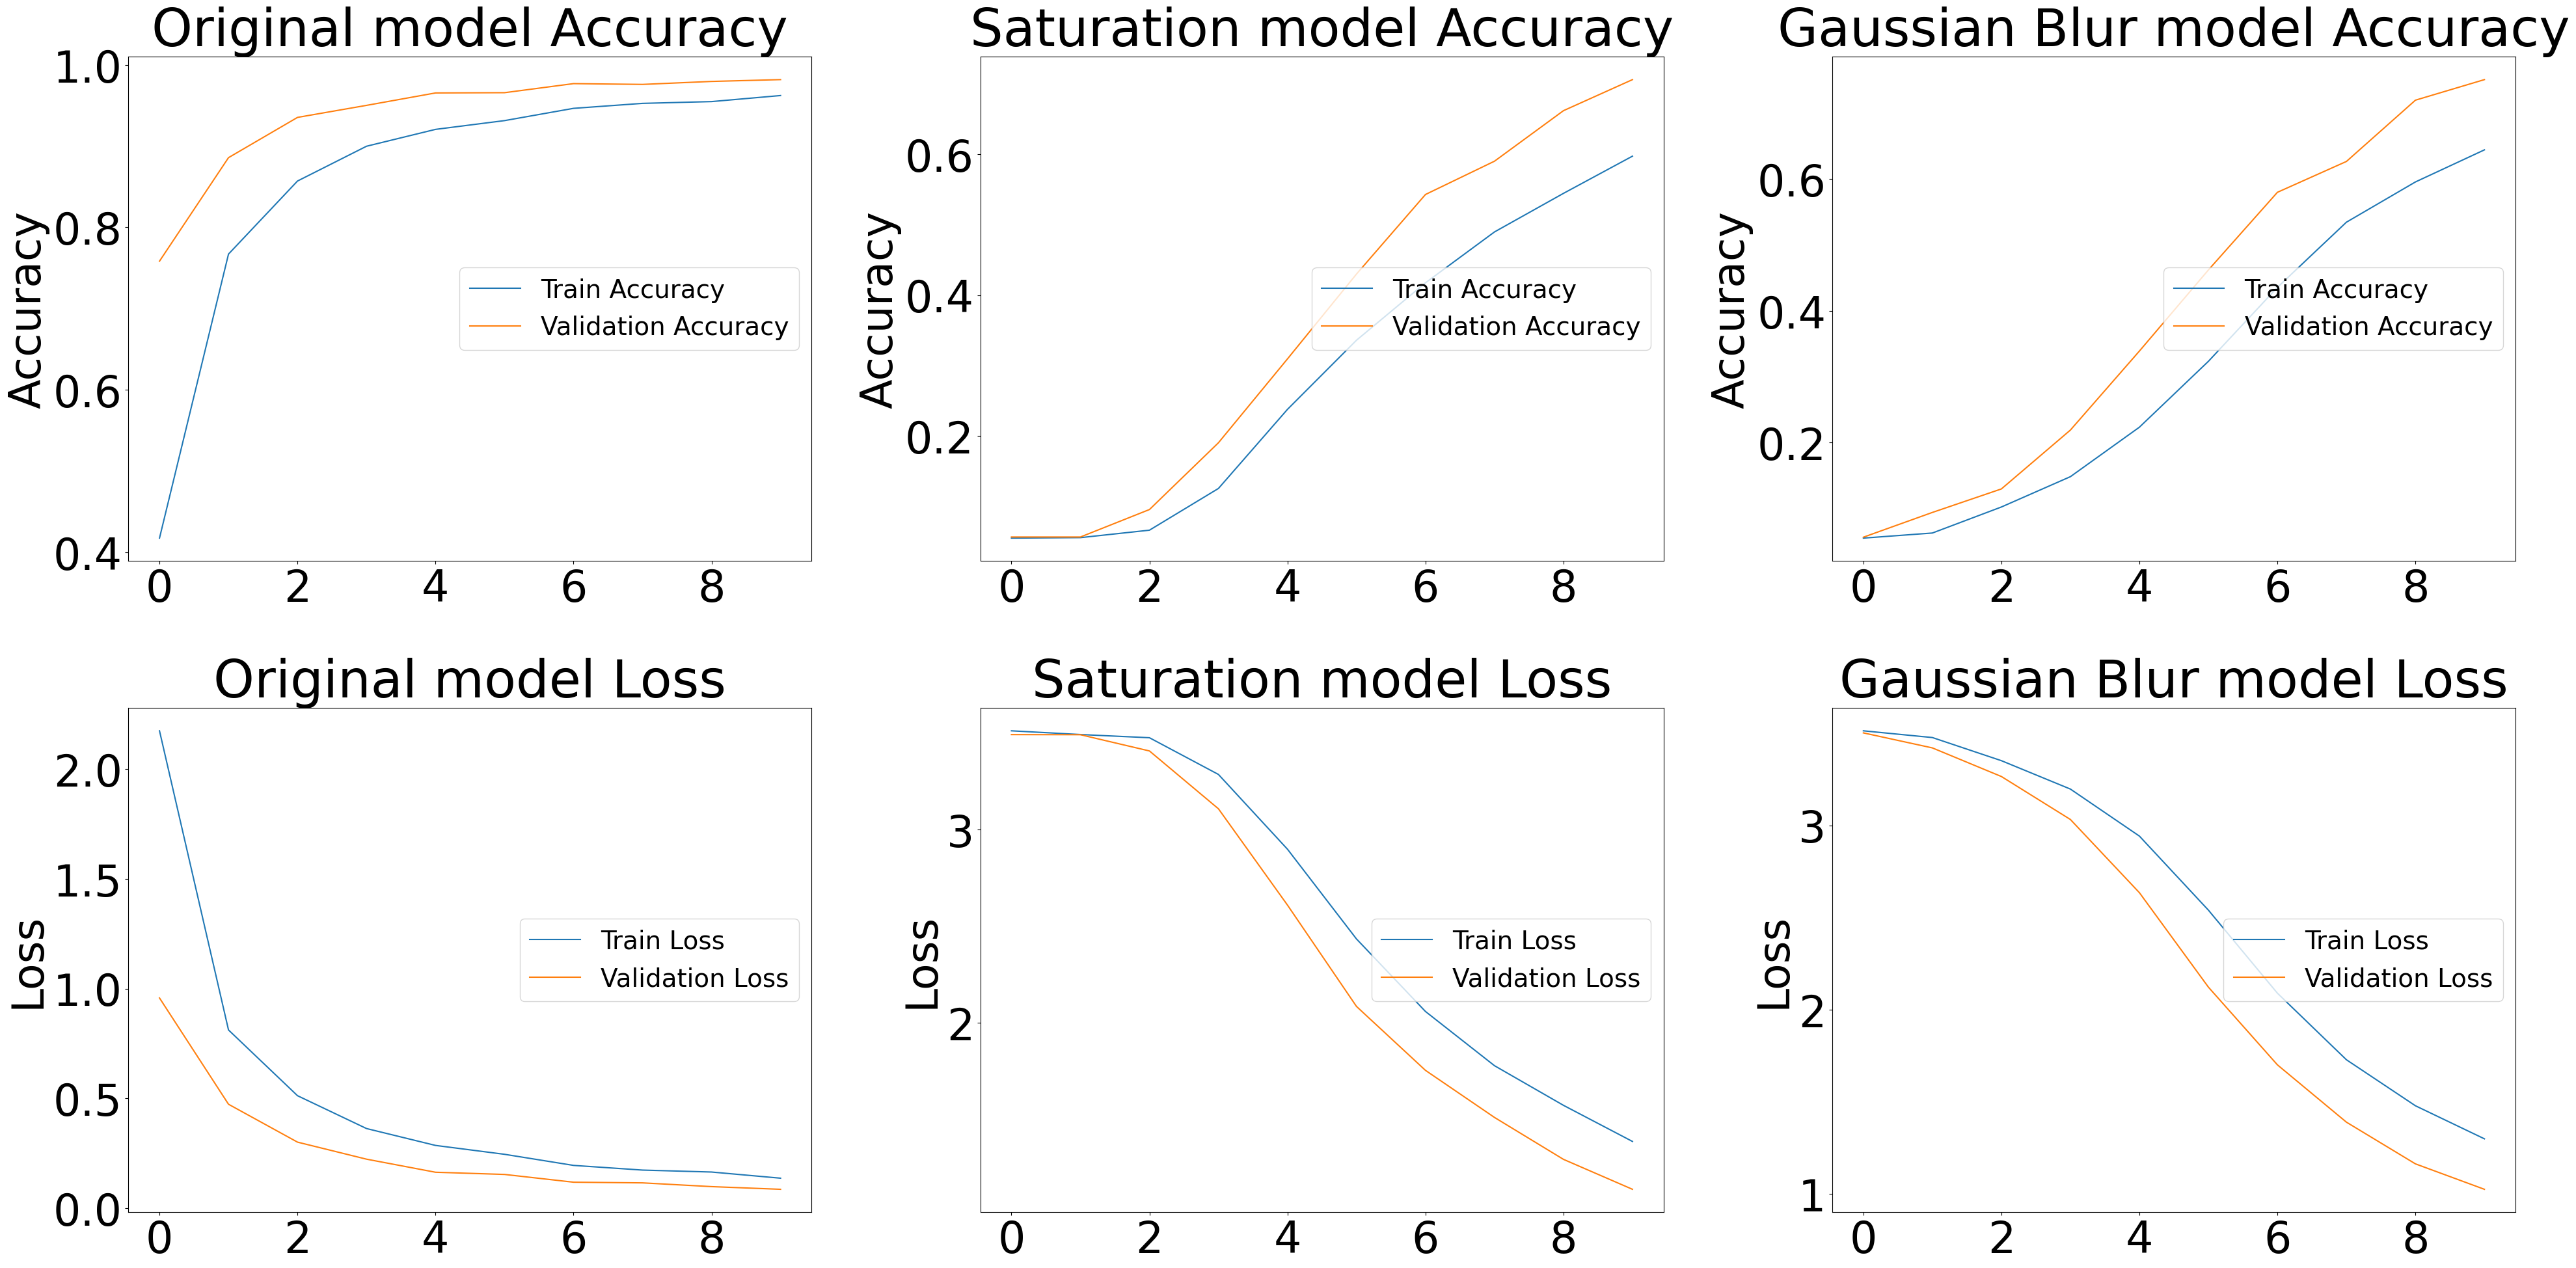

In [ ]:
#Horizontally oriented plot chart for display on presentation.
plt.rcParams.update({'font.size': 48})
plt.rcParams['legend.fontsize'] = 28
first_half = histories[:3]
second_half = histories[3:]
titles_first_half = titles[:3]
titles_second_half = titles[3:]


def plot_histories(histories, titles, figure_number):
    plt.figure(figsize=(40, 40), num=figure_number)
    for i, history in enumerate(histories):
        #Define dimensions for accuracy plot for each CNN.
        ax = plt.subplot(4, 3, i + 1)
        ax.plot(history.history['accuracy'], label='Train Accuracy')
        ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax.set_title(titles[i] + ' Accuracy')
        ax.set_ylabel('Accuracy')
        if i >= 3:
            ax.set_xlabel('Epoch')
        ax.legend(loc='center right', bbox_to_anchor=(1, 0.5))

        #Define dimensions for loss function plot for each CNN.
        ax = plt.subplot(4, 3, i + 4)
        ax.plot(history.history['loss'], label='Train Loss')
        ax.plot(history.history['val_loss'], label='Validation Loss')
        ax.set_title(titles[i] + ' Loss')
        ax.set_ylabel('Loss')
        if i >= 3:
            ax.set_xlabel('Epoch')
        ax.legend(loc='center right', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()


plot_histories(first_half, titles_first_half, 'Figure 1: Original, Saturation and Gaussian Blur CNNs')


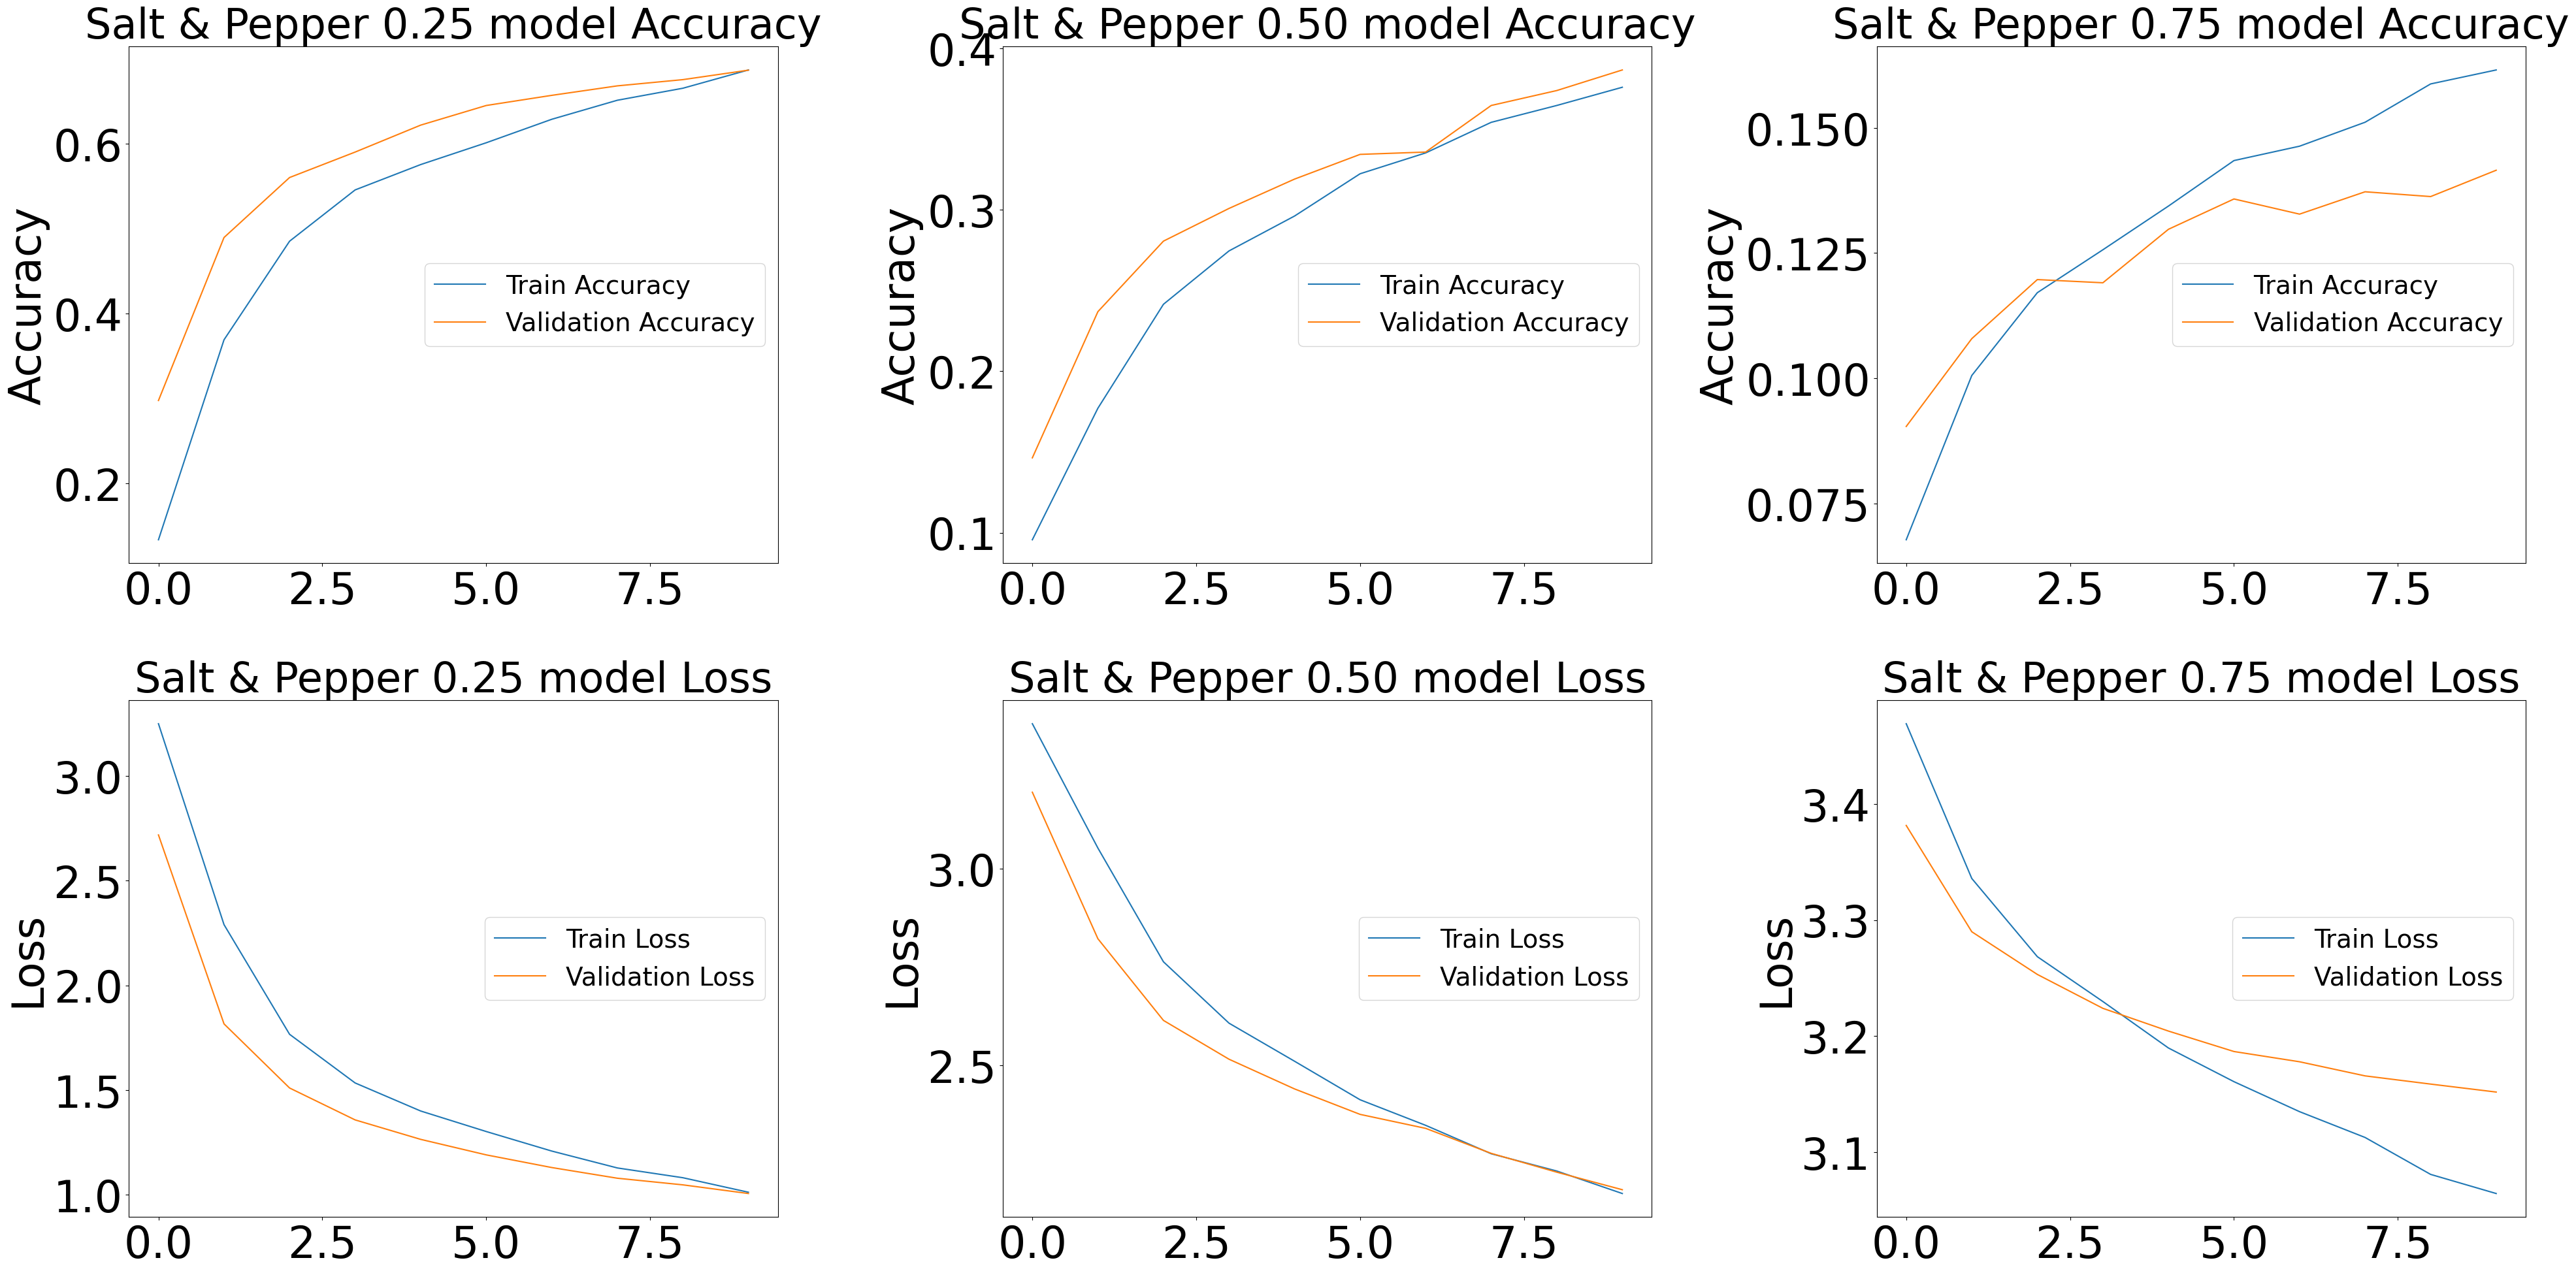

In [ ]:
plt.rcParams['axes.titlesize'] = 46
plot_histories(second_half, titles_second_half, 'Figure 2: Salt and Pepper CNNs')